In [1]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")


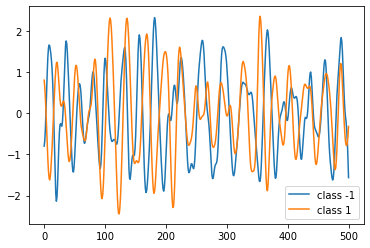

In [3]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

In [4]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [5]:
print(x_train.shape)

(3601, 500, 1)


In [6]:
num_classes = len(np.unique(y_train))
print(num_classes)

2


In [7]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [8]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [9]:
print(x_train.shape[1:])

(500, 1)


In [10]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)
    
    flatten_layer = keras.layers.Flatten()(gap)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(flatten_layer)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
epochs = 50
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/50
90/90 [==============================] - 7s 79ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.7073 - val_loss: 0.8811 - val_sparse_categorical_accuracy: 0.5090
Epoch 2/50
90/90 [==============================] - 7s 75ms/step - loss: 0.4663 - sparse_categorical_accuracy: 0.7688 - val_loss: 1.0261 - val_sparse_categorical_accuracy: 0.5090
Epoch 3/50
90/90 [==============================] - 7s 74ms/step - loss: 0.4388 - sparse_categorical_accuracy: 0.7844 - val_loss: 0.9568 - val_sparse_categorical_accuracy: 0.5090
Epoch 4/50
90/90 [==============================] - 7s 75ms/step - loss: 0.4434 - sparse_categorical_accuracy: 0.7750 - val_loss: 1.4636 - val_sparse_categorical_accuracy: 0.5090
Epoch 5/50
90/90 [==============================] - 7s 79ms/step - loss: 0.4212 - sparse_categorical_accuracy: 0.7958 - val_loss: 0.6415 - val_sparse_categorical_accuracy: 0.5992
Epoch 6/50
90/90 [==============================] - 8s 84ms/step - loss: 0.4075 - sparse_categorical_accu

90/90 [==============================] - 7s 78ms/step - loss: 0.2228 - sparse_categorical_accuracy: 0.9080 - val_loss: 0.4342 - val_sparse_categorical_accuracy: 0.7712
Epoch 47/50
90/90 [==============================] - 7s 79ms/step - loss: 0.2263 - sparse_categorical_accuracy: 0.9038 - val_loss: 0.3656 - val_sparse_categorical_accuracy: 0.8405
Epoch 48/50
90/90 [==============================] - 8s 84ms/step - loss: 0.2201 - sparse_categorical_accuracy: 0.9139 - val_loss: 0.3997 - val_sparse_categorical_accuracy: 0.8072
Epoch 49/50
90/90 [==============================] - 8s 84ms/step - loss: 0.2055 - sparse_categorical_accuracy: 0.9191 - val_loss: 0.2571 - val_sparse_categorical_accuracy: 0.9085
Epoch 50/50
90/90 [==============================] - 8s 84ms/step - loss: 0.2323 - sparse_categorical_accuracy: 0.9066 - val_loss: 1.4273 - val_sparse_categorical_accuracy: 0.5853


In [12]:
model = keras.models.load_model("best_model.h5")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

42/42 [==============================] - 0s 11ms/step - loss: 0.2367 - sparse_categorical_accuracy: 0.9129
Test accuracy 0.9128788113594055
Test loss 0.23673559725284576


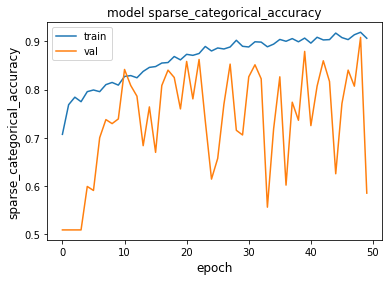

In [13]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()